In [ ]:
# Instala a biblioteca do Kaggle para baixar o dataset
!pip install kaggle

# Cria o diretório para a chave da API do Kaggle
!mkdir -p ~/.kaggle

# Copia o arquivo kaggle.json que você subiu para o diretório correto
!cp kaggle.json ~/.kaggle/

# Define as permissões corretas para o arquivo da chave
!chmod 600 ~/.kaggle/kaggle.json

# Baixa o dataset do Kaggle
!kaggle datasets download -d siddhrajthakor/fbref-premier-league-202425-player-stats-dataset

# Descompacta o arquivo.zip que foi baixado
!unzip fbref-premier-league-202425-player-stats-dataset.zip

print("\n--- Ambiente configurado e dataset baixado com sucesso! ---")

Dataset URL: https://www.kaggle.com/datasets/siddhrajthakor/fbref-premier-league-202425-player-stats-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/28.7k [00:00<?, ?B/s]
100% 28.7k/28.7k [00:00<00:00, 99.2MB/s]
Archive:  fbref-premier-league-202425-player-stats-dataset.zip
  inflating: fbref_PL_2024-25.csv    

--- Ambiente configurado e dataset baixado com sucesso! ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Carrega o arquivo CSV para um DataFrame do pandas
# Tenta diferentes codificações caso a padrão falhe
try:
    df = pd.read_csv('fbref_PL_2024-25.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('fbref_PL_2024-25.csv', encoding='latin1')

# Seleciona apenas as colunas numéricas para a análise
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

# Lista de colunas para excluir da análise (não representam performance em campo)
cols_to_exclude = ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Matches', 'Starts']
features = [col for col in numeric_cols if col not in cols_to_exclude]
df_features = df[features].copy()

# Preenche valores ausentes (NaN) com 0
# A premissa é que um valor ausente significa que a ação não foi realizada
df_features.fillna(0, inplace=True)

# Padroniza os dados (escala) para que o K-Means funcione corretamente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

print("--- Dados carregados, limpos e preparados para análise! ---")
print(f"Formato dos dados para o modelo: {X_scaled.shape}")

--- Dados carregados, limpos e preparados para análise! ---
Formato dos dados para o modelo: (574, 28)


--- Gerando Gráficos da Análise Exploratória ---


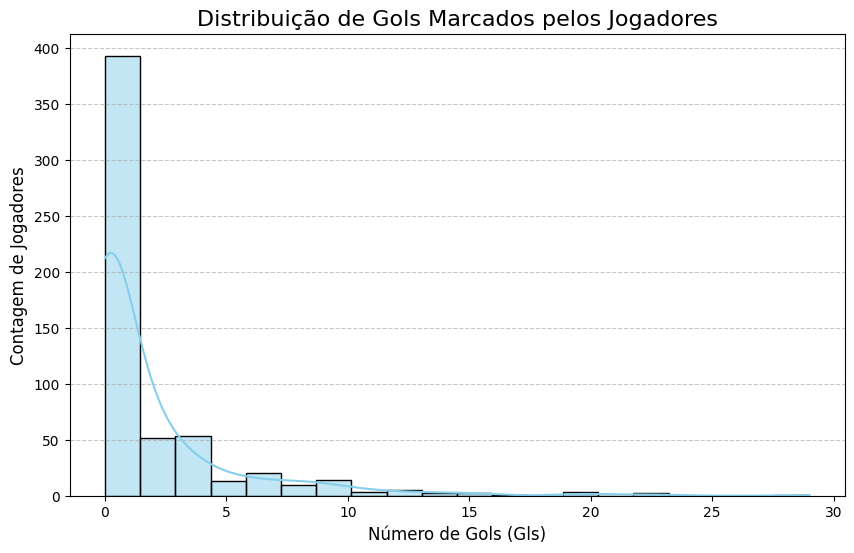

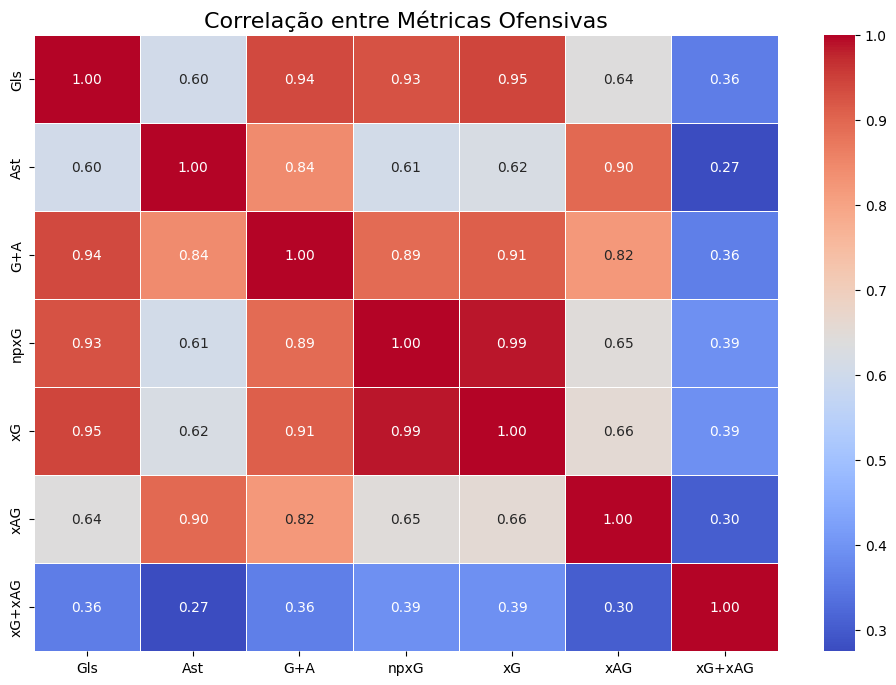

In [ ]:
print("--- Gerando Gráficos da Análise Exploratória ---")

# Gráfico 1: Histograma da Distribuição de Gols
plt.figure(figsize=(10, 6))
sns.histplot(df_features['Gls'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição de Gols Marcados pelos Jogadores', fontsize=16)
plt.xlabel('Número de Gols (Gls)', fontsize=12)
plt.ylabel('Contagem de Jogadores', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico 2: Mapa de Calor de Correlações
# Selecionamos algumas métricas ofensivas para uma visualização mais clara
# Check available columns in df_features
available_cols = df_features.columns.tolist()
corr_features = [col for col in ['Gls', 'Ast', 'G+A', 'Sh', 'SoT', 'npxG', 'xG', 'xAG', 'xG+xAG'] if col in available_cols]
correlation_matrix = df_features[corr_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlação entre Métricas Ofensivas', fontsize=16)
plt.show()

--- Executando o Método do Cotovelo para encontrar o K ótimo ---


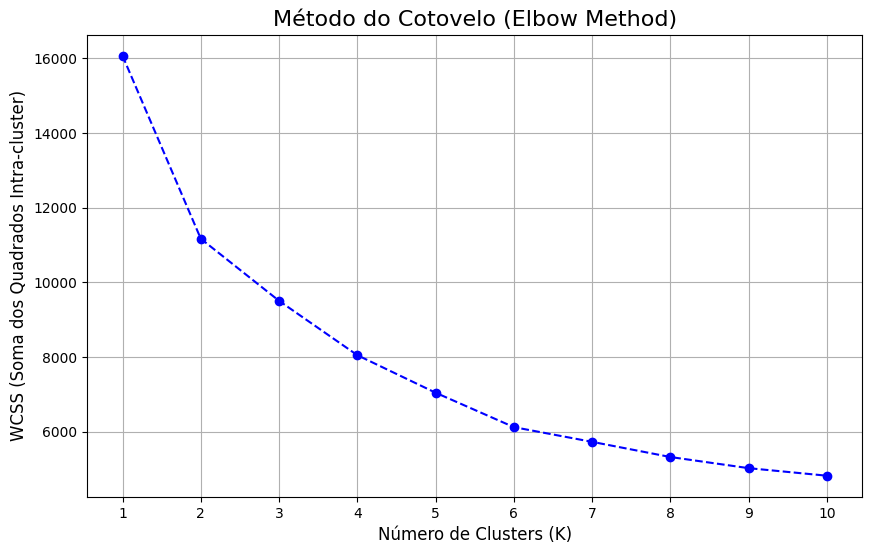

In [ ]:
from sklearn.cluster import KMeans

print("--- Executando o Método do Cotovelo para encontrar o K ótimo ---")

wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Gráfico do Método do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='b')
plt.title('Método do Cotovelo (Elbow Method)', fontsize=16)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('WCSS (Soma dos Quadrados Intra-cluster)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Definimos o número ótimo de clusters que encontramos com o Método do Cotovelo
optimal_k = 5

# Aplica o K-Means com o número ótimo de clusters
# Usamos os mesmos parâmetros para garantir a reprodutibilidade
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled) # X_scaled são os dados que você já preparou

# Adiciona os resultados dos clusters de volta ao DataFrame original para futuras análises
# (Isso não é usado agora, mas é uma boa prática)
df['Cluster'] = clusters

# --- 1. Cálculo das Métricas de Acurácia ---
# Calcula as métricas de avaliação para validar a qualidade dos clusters
silhouette = silhouette_score(X_scaled, clusters)
calinski = calinski_harabasz_score(X_scaled, clusters)
davies = davies_bouldin_score(X_scaled, clusters)

print("--- Medidas de Acurácia para K=5 ---")
print(f"Coeficiente de Silhueta Médio: {silhouette:.4f}")
print(f"Índice Calinski-Harabasz: {calinski:.4f}")
print(f"Índice Davies-Bouldin: {davies:.4f}")
print("\n") # Adiciona uma linha em branco para separar

# --- 2. Análise dos Centroides ---
# Os centroides são os "jogadores médios" de cada cluster.
# Precisamos reverter a escala para interpretar os valores reais.
centroids_scaled = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids_scaled)

# Cria uma tabela (DataFrame) com os centroides para facilitar a visualização
df_centroids = pd.DataFrame(centroids_original_scale, columns=features)

# Seleciona algumas das métricas mais importantes para exibir na tabela de resultados
# Filtra para incluir apenas as colunas que realmente existem no DataFrame de centroides
all_possible_features_to_show = ['Gls', 'Ast', 'G+A', 'Sh', 'SoT', 'npxG', 'xG', 'xAG', 'xG+xAG', 'PrgP', 'PrgC', 'TklW', 'Int', 'Clr', 'Blocks', 'Touches', 'Carries', 'Succ', 'Att', 'Cmp%', 'Prog', 'Rec', 'KP', 'Fld', 'Off', 'Crs', 'TI', 'PK']
features_to_show = [feature for feature in all_possible_features_to_show if feature in df_centroids.columns]


print("--- Análise dos Centroides (Valores Médios por Cluster) ---")
print(df_centroids[features_to_show].round(2))

--- Medidas de Acurácia para K=5 ---
Coeficiente de Silhueta Médio: 0.3243
Índice Calinski-Harabasz: 182.4237
Índice Davies-Bouldin: 1.1258


--- Análise dos Centroides (Valores Médios por Cluster) ---
    Gls   Ast    G+A  npxG    xG   xAG  xG+xAG   PrgP   PrgC    PK
0  1.44  1.70   3.14  1.65  1.69  1.80    0.15  89.38  34.53  0.02
1  9.62  5.71  15.33  8.04  8.91  5.34    0.52  99.08  84.48  0.98
2  2.78  1.27   4.05  2.51  2.57  1.26    0.56  22.78  17.68  0.05
3  0.00  0.00  -0.00  0.27  0.27  0.00    3.20   0.33   0.00  0.00
4  0.17  0.20   0.37  0.28  0.28  0.26    0.12  14.73   5.57 -0.00


-> Gráfico 1 (Radar) gerado. Insira este print na seção 4.1 para ilustrar os perfis.




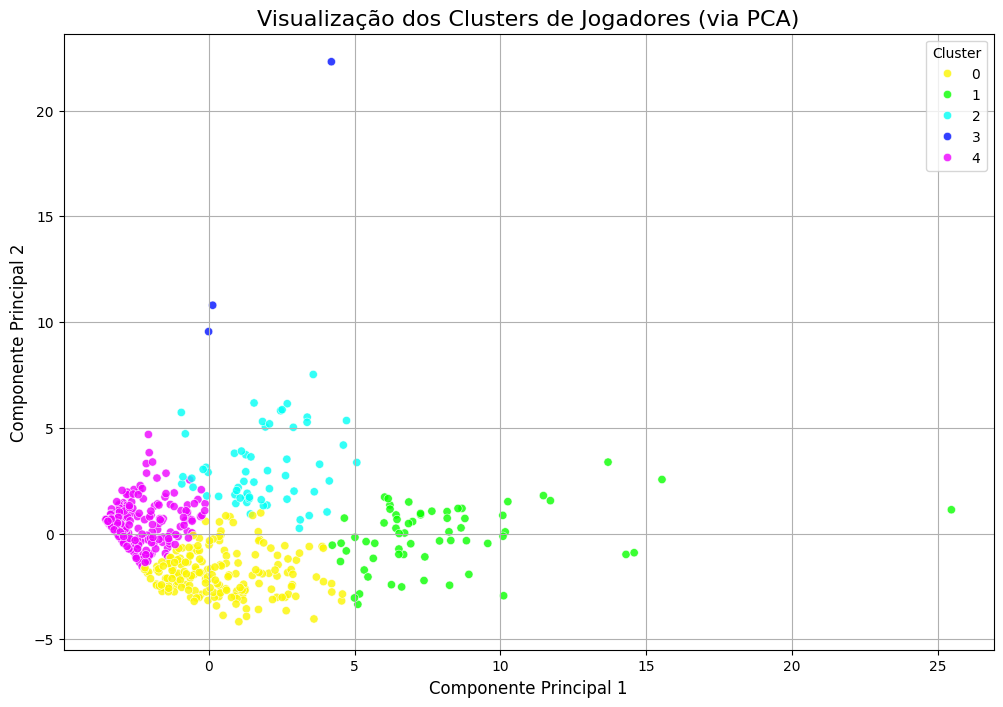

-> Gráfico 2 (PCA) gerado. Este gráfico pode ser usado para mostrar a separação dos grupos.


In [ ]:
# ==============================================================================
# VISUALIZAÇÃO GRÁFICA DOS RESULTADOS DA CLUSTERIZAÇÃO
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go # Usaremos plotly para um gráfico de radar interativo

# --- Gráfico 1: Gráfico de Radar para Comparar os Perfis dos Clusters ---

# Para o gráfico de radar, é melhor normalizar os centroides entre 0 e 1
# para que todas as métricas fiquem na mesma escala no gráfico.
scaler_radar = MinMaxScaler()
df_centroids_normalized = pd.DataFrame(scaler_radar.fit_transform(df_centroids[features_to_show]), columns=features_to_show)

# Prepara as categorias (eixos do gráfico)
categories = features_to_show
fig = go.Figure()

# Adiciona um "traço" (uma forma) para cada cluster no gráfico de radar
for i in range(optimal_k):
    fig.add_trace(go.Scatterpolar(
        r=df_centroids_normalized.iloc[i].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {i}'
    ))

# Personaliza o layout do gráfico
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
  title="Comparativo de Perfis dos Clusters (Gráfico de Radar)"
)

fig.show()
print("-> Gráfico 1 (Radar) gerado. Insira este print na seção 4.1 para ilustrar os perfis.")
print("\n")

# --- Gráfico 2: Gráfico de Dispersão com PCA para Visualizar a Separação dos Clusters ---

# Reduzimos todas as métricas para apenas 2 dimensões usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) # Usamos os dados escalados originais

# Cria um novo DataFrame com as dimensões reduzidas e os labels dos clusters
df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['Cluster'] = clusters

# Generates the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="Componente Principal 1", y="Componente Principal 2",
    hue="Cluster",
    palette=sns.color_palette("hsv", n_colors=optimal_k),
    data=df_pca,
    legend="full",
    alpha=0.8
)
plt.title('Visualização dos Clusters de Jogadores (via PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.grid(True)
plt.show()
print("-> Gráfico 2 (PCA) gerado. Este gráfico pode ser usado para mostrar a separação dos grupos.")